In [1]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

In [2]:
%run optimization_criterions.ipynb

In [3]:
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df = pd.concat([df, temp_df], axis=1)
    df.index.names = ['time']
    df.index = pd.to_datetime(df.index, unit='s')
    df = df.dropna().pct_change().dropna()

In [4]:
split = int(0.7*len(df))
train_set = df.iloc[:split, :]
test_set = df.iloc[split:, :]
# Encontrar el número de activos
n = df.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución de los problemas de optimización
res_MV = minimize(MV_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SK = minimize(SK_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SR = minimize(SR_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SOR = minimize(SOR_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
# ResultadoS
X_MV = res_MV.x
X_SK = res_SK.x
X_SR = res_SR.x
X_SOR = res_SOR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2494048820498898
            Iterations: 35
            Function evaluations: 3535
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3142073304133675
            Iterations: 14
            Function evaluations: 1418
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0703009107147697
            Iterations: 24
            Function evaluations: 2426
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.17027202847774933
            Iterations: 18
            Function evaluations: 1835
            Gradient evaluations: 18


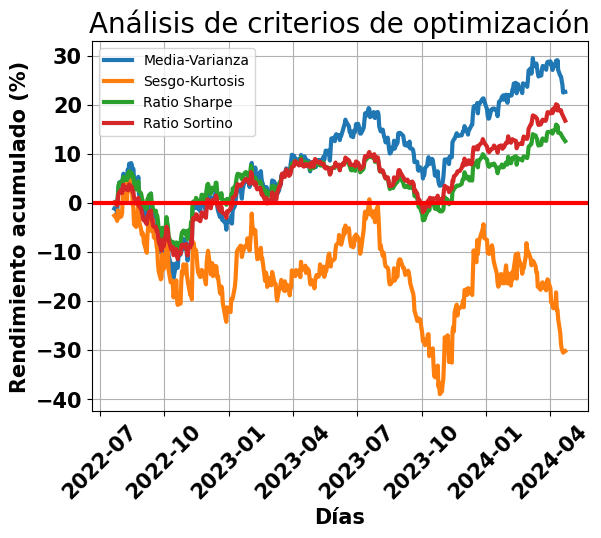

In [5]:
# Calcular la retabilidad acumulada de la cartera
portfolio_return_MV = np.multiply(test_set, np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)
portfolio_return_SK = np.multiply(test_set, np.transpose(X_SK))
portfolio_return_SK = portfolio_return_SK.sum(axis=1)
portfolio_return_SR = np.multiply(test_set, np.transpose(X_SR))
portfolio_return_SR = portfolio_return_SR.sum(axis=1)
portfolio_return_SOR = np.multiply(test_set, np.transpose(X_SOR))
portfolio_return_SOR = portfolio_return_SOR.sum(axis=1)
portfolio_strategies = pd.concat(
   [
      portfolio_return_MV,
      portfolio_return_SK,
      portfolio_return_SR,
      portfolio_return_SOR
   ], axis=1)
portfolio_strategies.columns = columns=[
   "Media-Varianza", 
   "Sesgo-Kurtosis", 
   "Ratio Sharpe",
   "Ratio Sortino"]

# Representar el CM
for column in portfolio_strategies.columns:
    plt.plot(np.cumsum(portfolio_strategies[column]) * 100, linewidth=3, label=column)

plt.ylabel("Rendimiento acumulado (%)", size=15, fontweight='bold')
plt.xlabel("Días", size=15, fontweight='bold')
plt.xticks(rotation=45) 
plt.xticks(size=15, fontweight='bold')
plt.yticks(size=15, fontweight='bold')
plt.title("Análisis de criterios de optimización", size=20)
plt.axhline(0, color='r', linewidth=3)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()